# YOLOv5






## Импорт библиотек

In [1]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями и построения модели
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display

## Загрузка данных

In [2]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

In [3]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Конвертация прошла успешно.')

100%|██████████| 3503/3503 [00:15<00:00, 226.89it/s]

Конвертация прошла успешно.


In [5]:
xml_df = xml_df[:100]

In [6]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_000001.jpg,3,333,500,cat,123,13,341,313
1,2010_000001.jpg,3,333,500,chair,294,13,410,236
2,2010_000001.jpg,3,333,500,chair,418,198,500,290
3,2010_000001.jpg,3,333,500,chair,362,1,498,80
4,2010_000001.jpg,3,333,500,diningtable,1,219,500,333


In [7]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 100
Количество изображений в датафрэйме 48


## Обработка данных 

Закодируем классы обьектов.

In [8]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [9]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_000001.jpg,3,333,500,7,123,13,341,313
1,2010_000001.jpg,3,333,500,8,294,13,410,236
2,2010_000001.jpg,3,333,500,8,418,198,500,290
3,2010_000001.jpg,3,333,500,8,362,1,498,80
4,2010_000001.jpg,3,333,500,10,1,219,500,333


Сохраним кодировку классов в переменной mapping.

In [10]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [11]:
mapping

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

Теперь нам нужно привести наши данные к формату **YOLOv5**.

Аннотация каждого объекта должна сожержать следующую информацию:

`Class X Y Width Height`

![picture](https://drive.google.com/uc?export=view&id=1yUJt5XTvYo4MbWxKAxhPdCk-yCnQ1AEz)


Для этого воспользуемся вспомогательной функцией `convert_to_yolov5`.



In [12]:
def convert_to_yolov5(df, unique_img_names):

    df_array = np.array(df)

    # Для каждого объкта
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        # Для каждого уникального изображения
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:
              class_id = point[4]
      
              # Преобразуем координаты bbox 
              X = (point[5] + point[7]) / 2 
              Y = (point[6] + point[8]) / 2 
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])
              
              # Нормализуем координаты
              image_c, image_w, image_h = point[1], point[2], point[3] 
              X /= image_w 
              Y /= image_h 
              Width    /= image_w 
              Height   /= image_h 
              
              # Запишем информацию о bbox в файл
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
              
        # Дадим имя файлам, которые хотим сохранить
        save_file_label = os.path.join("./datasets/homework/labels", img_name.replace("jpg", "txt"))
        folder = "./VOCdevkit/VOC2012/JPEGImages/"
        toImgFolder = "./datasets/homework/images/"
        fromImgPath = os.path.join(folder, img_name)
        toImgPath = os.path.join(toImgFolder, img_name)
        # Сохраним аннотации на диск
        print("\n".join(print_buffer), file= open(save_file_label, "w"))
        shutil.copyfile(fromImgPath, toImgPath)

In [13]:
# Для начала выделим список уникальных имен изображений
unique_img_names = xml_df['filename'].unique()
print(len(unique_img_names))

48


In [14]:
# Получим аннотации в новом формате
convert_to_yolov5(xml_df, unique_img_names)

Давайте протестируем трансформированные аннотиции с помощью визуализации.

In [15]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))

In [16]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")
    
    
    plt.imshow(np.array(image))
    plt.show()

In [17]:
import random

# Выберем рандомную аннотацию 
annotation_random = random.choice(os.listdir("./datasets/homework/labels/"))

In [18]:
annotation_random

'2010_000056.txt'

[[1.    0.667 0.341 1.071 0.39 ]]


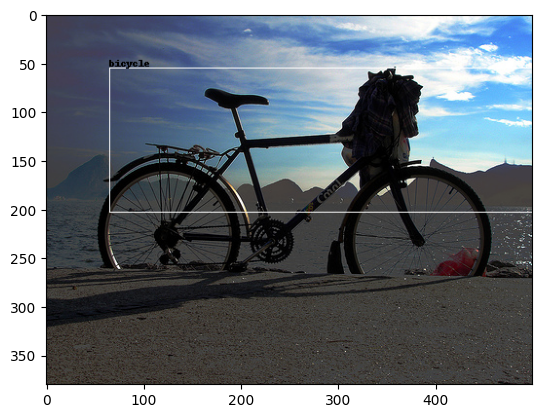

In [19]:
# Выберем рандомную аннотацию 
annotation_file = os.path.join("./datasets/homework/labels/", annotation_random)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_random = annotation_random.replace("txt", "jpg")
jpgPath = os.path.join("./datasets/homework/images/", image_random)
assert os.path.exists(jpgPath)

#Load the image
image = Image.open(jpgPath)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Обученная модель находится в классе hub библиотеки `torch`.

Давайте посмотрим на предсказания модели для нашей рандомной картинки.

In [20]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s') 

img = annotation_random[0].replace("txt", "jpg")

# Inference
results = model(jpgPath)

# Results
results.print()

Using cache found in C:\Users\ilkhom-pc/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-3-16 Python-3.9.16 torch-1.10.1+cu113 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 380x500 1 bicycle
Speed: 8.5ms pre-process, 42.0ms inference, 6.0ms NMS per image at shape (1, 3, 512, 640)


## ЗАДАНИЕ

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

In [21]:
# Код который по идее должен работать на Юникс системах
!python ./yolov5/train.py --data ./yolov5/homework.yaml --weights yolov5s.pt --img 640

# Но так как у меня Виндоус, мне пришлось отрабатывать нижеприведенный код на cmd, используя среду Anaconda и версию пакетов с именем cv которую я создал для учебного трека
# conda run -n cv python "./yolov5/train.py" --img 640 --batch 1 --epochs 1 --data ./yolov5/homework.yaml --weights yolov5s.pt

<h1 style="font-size:14px">PS D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4> conda run -n cv python "./yolov5/train.py" --img 640 --batch 1 --epochs 1 --data ./yolov5/homework.yaml --weights yolov5s.pt

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5

wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: thenexus85. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=./yolov5/homework.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5  2023-4-3 Python-3.9.16 torch-1.10.1+cu113 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
ClearML: run 'pip install clearml' to automatically track, visualize and remotely train YOLOv5  in ClearML
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5  runs in Comet
TensorBoard: Start with 'tensorboard --logdir yolov5\runs\train', view at http://localhost:6006/
wandb: wandb version 0.14.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\wandb\run-20230413_183658-orc6dkyf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run upbeat-blaze-4
wandb:  View project at https://wandb.ai/thenexus85/train
wandb:  View run at https://wandb.ai/thenexus85/train/runs/orc6dkyf
Overriding model.yaml nc=80 with nc=20

                 from  n    params  module                                  arguments
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]
  2                -1  1     18816  models.common.C3                        [64, 64, 1]
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]
  4                -1  2    115712  models.common.C3                        [128, 128, 2]
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]
  6                -1  3    625152  models.common.C3                        [256, 256, 3]
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]
  8                -1  1   1182720  models.common.C3                        [512, 512, 1]
  9                -1  1    656896  models.common.SPPF                      [512, 512, 5]
 10                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']
 12           [-1, 6]  1         0  models.common.Concat                    [1]
 13                -1  1    361984  models.common.C3                        [512, 256, 1, False]
 14                -1  1     33024  models.common.Conv                      [256, 128, 1, 1]
 15                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']
 16           [-1, 4]  1         0  models.common.Concat                    [1]
 17                -1  1     90880  models.common.C3                        [256, 128, 1, False]
 18                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]
 19          [-1, 14]  1         0  models.common.Concat                    [1]
 20                -1  1    296448  models.common.C3                        [256, 256, 1, False]
 21                -1  1    590336  models.common.Conv                      [256, 256, 3, 2]
 22          [-1, 10]  1         0  models.common.Concat                    [1]
 23                -1  1   1182720  models.common.C3                        [512, 512, 1, False]
 24      [17, 20, 23]  1     67425  models.yolo.Detect                      [20, [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], [128, 256, 512]]
Model summary: 214 layers, 7073569 parameters, 7073569 gradients, 16.1 GFLOPs

Transferred 343/349 items from yolov5s.pt
AMP: checks passed
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 60 weight(decay=0.0005), 60 bias
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
train: Scanning D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\labels.cache... 48 images, 0 backgrounds, 22 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000003.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.168]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000015.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.205]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000020.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.498]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000035.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.48]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000036.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.112]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000043.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.324]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000045.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.328]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000048.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.173]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000050.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.152]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000053.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.165]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.292]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000055.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.277]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.071]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000061.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.064]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000069.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.172]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000073.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.471]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000074.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.228]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000080.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.404]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000085.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.498]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000087.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.289]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000088.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.331]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000090.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.208]      
val: Scanning D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\labels.cache... 48 images, 0 backgrounds, 22 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000003.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.168]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000015.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.205]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000020.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.498]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000035.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.48]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000036.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.112]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000043.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.324]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000045.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.328]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000048.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.173]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000050.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.152]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000053.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.165]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.292]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000055.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.277]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.071]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000061.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.064]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000069.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.172]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000073.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.471]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000074.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.228]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000080.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.404]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000085.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.498]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000087.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.289]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000088.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.331]      
train: WARNING  D:\Projects\DataScience\SkillFactory\DATA_ANALYST\CV-4\datasets\homework\images\2010_000090.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.208]      
wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: thenexus85. Use `wandb login --relogin` to force relogin
wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: thenexus85. Use `wandb login --relogin` to force relogin

AutoAnchor: 3.46 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset
Plotting labels to yolov5\runs\train\exp4\labels.jpg...
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to yolov5\runs\train\exp4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        0/0     0.476G    0.07787    0.03013    0.05334          2        640: 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]
                   all         26         26          0          0          0          0

1 epochs completed in 0.003 hours.
Optimizer stripped from yolov5\runs\train\exp4\weights\last.pt, 14.5MB
Optimizer stripped from yolov5\runs\train\exp4\weights\best.pt, 14.5MB

Validating yolov5\runs\train\exp4\weights\best.pt...
Fusing layers...
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 13/13 [00:00<00:00, 14.54it/s]
                   all         26         26          0          0          0          0
Results saved to yolov5\runs\train\exp4
wandb: Waiting for W&B process to finish... (success).
wandb:
wandb: Run history:
wandb:      metrics/mAP_0.5 ▁▁
wandb: metrics/mAP_0.5:0.95 ▁▁
wandb:    metrics/precision ▁▁
wandb:                x/lr0 0.0775
wandb:                x/lr1 0.0025
wandb:                x/lr2 0.0025
wandb:
wandb:  View run upbeat-blaze-4 at: https://wandb.ai/thenexus85/train/runs/orc6dkyf
wandb: Synced 6 W&B file(s), 13 media file(s), 3 artifact file(s) and 0 other file(s)
wandb: Find logs at: .\wandb\run-20230413_183658-orc6dkyf\logs
wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.</h1>

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.

In [1]:
!tensorboard --logdir "./yolov5/runs/train/"

^C
